# Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

## Imports for the project

In [117]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import os

from moviepy.editor import VideoFileClip

# Plot in a new window
%matplotlib qt

## Helper Functions

In [3]:
def create_directory(path):
    try:
        if not os.path.exists(path):
            os.mkdir(path)
    except OSError:  
        print ("Creation of the directory %s failed" % output_path)

## Step 1. Compute the camera calibration using chessboard images

---

In [4]:
# Camera Calibration Config
board_width = 9
board_height = 6
###########################

In [5]:
def calibrate_camera():
    # Make a list of calibration images
    images = glob.glob('../camera_cal/calibration*.jpg')

    # Create output calibration path
    output_path = '../output_images/camera_calibration/'

    create_directory(output_path)
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((board_width*board_height,3), np.float32)
    objp[:,:2] = np.mgrid[0:board_width,0:board_height].T.reshape(-1,2) # x, y corrdinates

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    image_shape = (0,0)

    # Step through the list and search for chessboard corners
    for fname in images:
        img = mpimg.imread(fname)
        image_shape = img.shape[1::-1]
        file_name = fname[fname.rfind('/') + 1:]
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (board_width, board_height), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (board_width, board_height), corners, ret)
            plt.imsave(output_path + file_name, img)
            
    return objpoints, imgpoints, image_shape

In [7]:
# Calibrate the camera to give 
objpoints, imgpoints, image_shape = calibrate_camera()
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)

**Results will be in output_images/camera_calibration/**

## Step 2 Applying a distortion correction to raw images.

In [8]:
# Now that we have calibrated the camera let's try undistorting an image
def undistort_img(img, objpoints, imgpoints):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

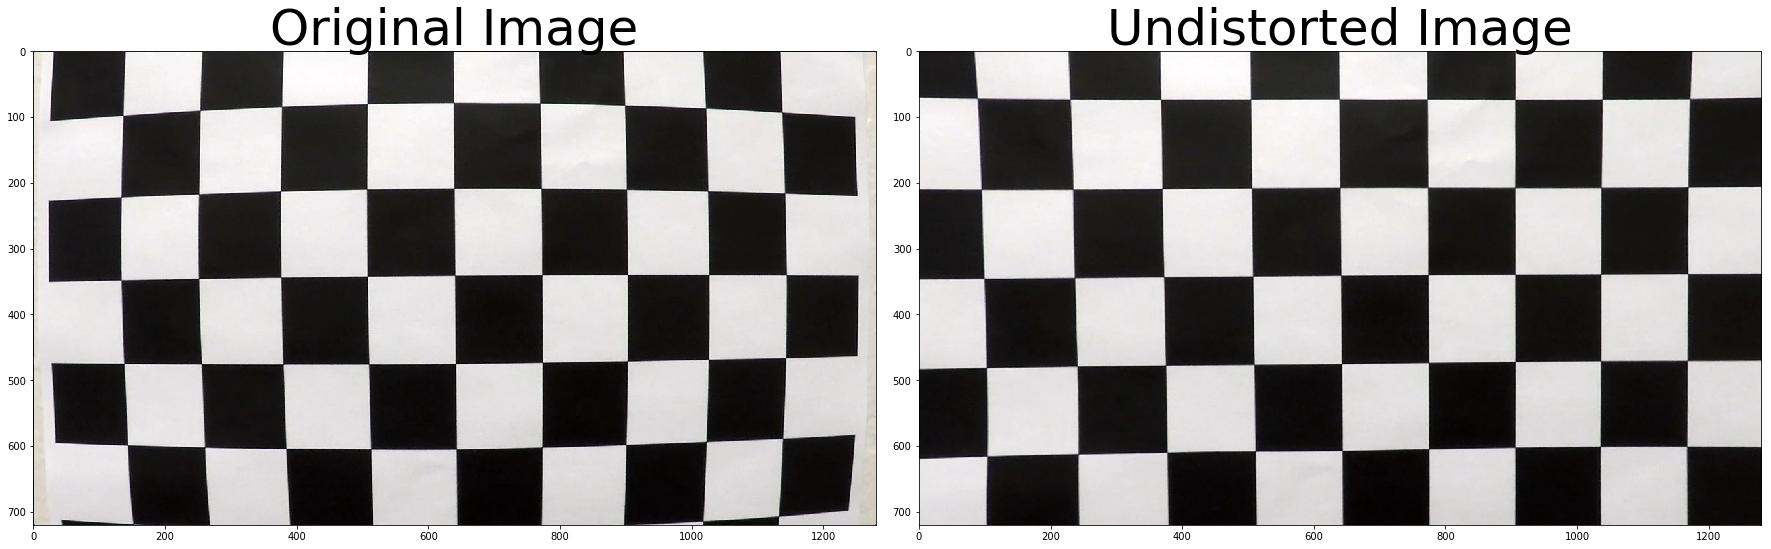

In [9]:
def undistort_test():
    # Read in an image
    img = mpimg.imread('../camera_cal/calibration1.jpg')

    undistorted = undistort_img(img, objpoints, imgpoints)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title('Undistorted Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
undistort_test()

## Step 3. Create a binary graident that enhance the visibility of the lane lines. ##

### Gradient helper functions

In [10]:
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, sobel_thresh=(0, 255)):
    # Calculate directional gradient
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Apply threshold
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel <= sobel_thresh[1])] = 1

    return grad_binary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude 
    abs_sobelxy = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # Apply threshold
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary

def dir_threshold(image, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(abs_sobely, abs_sobelx)
    
    # Apply threshold
    # 5) Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= dir_thresh[0]) & (direction <= dir_thresh[1])] = 1
    
    return dir_binary


### Create combined gradient

In [11]:
# Gradient Config

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

##################

In [82]:
def build_shape_gradient(image, sobel_kernel):    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=sobel_kernel, sobel_thresh=(30, 150))
    grady = abs_sobel_thresh(image, orient='y', sobel_kernel=sobel_kernel, sobel_thresh=(30, 150))
    mag_binary = mag_thresh(image, sobel_kernel=sobel_kernel, mag_thresh=(50, 200))
    dir_binary = dir_threshold(image, sobel_kernel=sobel_kernel, dir_thresh=(0.7, 1.2))

    combined_gradient = np.zeros_like(dir_binary)
    combined_gradient[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return (gradx, grady, mag_binary, dir_binary, combined_gradient)

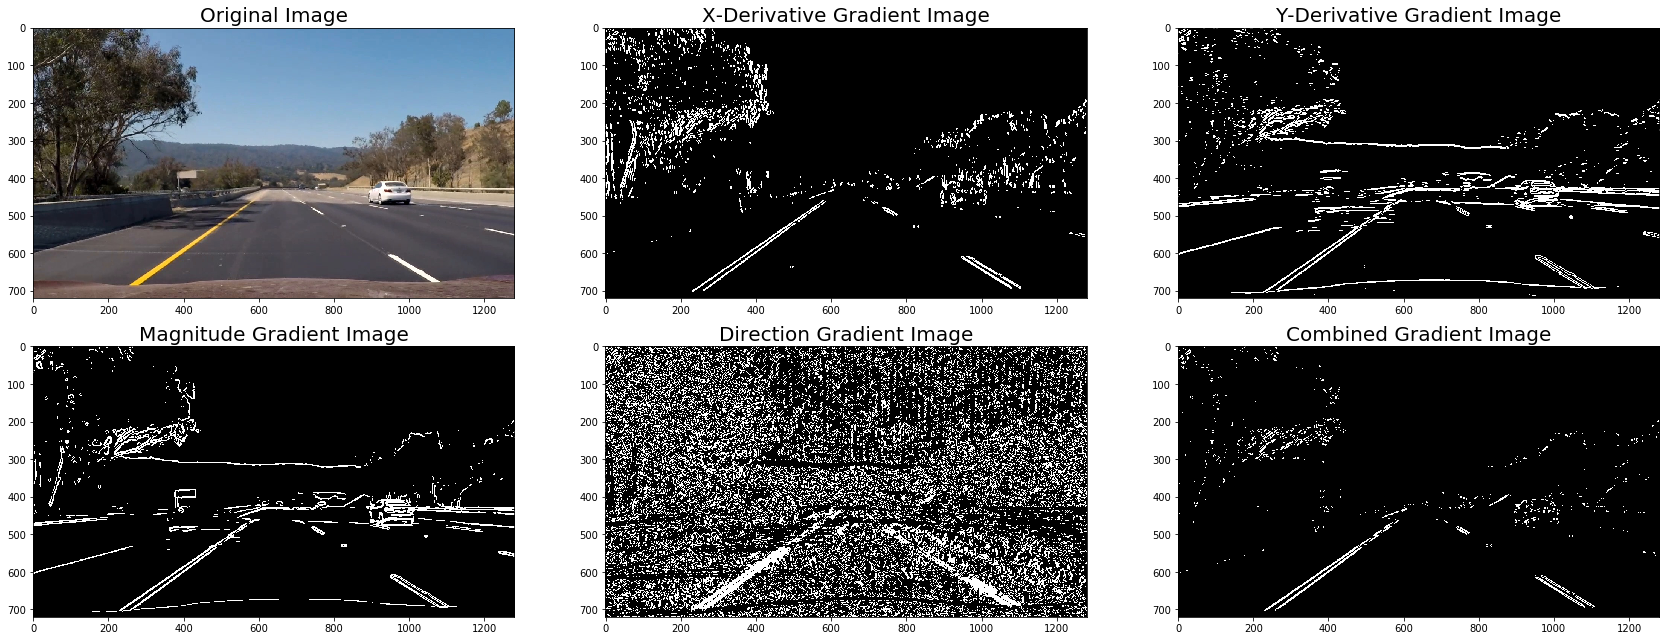

In [81]:
def gradient_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_14.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)

    gradx, grady, mag_binary, dir_binary, combined_shape_gradient = build_shape_gradient(undistorted_img, ksize)

    f, axes = plt.subplots(2, 3, figsize=(24, 9))
    axes[0, 0].imshow(image)
    axes[0, 0].set_title('Original Image', fontsize=20)

    axes[0, 1].imshow(gradx, cmap='gray')
    axes[0, 1].set_title('X-Derivative Gradient Image', fontsize=20)

    axes[0, 2].imshow(grady, cmap='gray')
    axes[0, 2].set_title('Y-Derivative Gradient Image', fontsize=20)

    axes[1, 0].imshow(mag_binary, cmap='gray')
    axes[1, 0].set_title('Magnitude Gradient Image', fontsize=20)

    axes[1, 1].imshow(dir_binary, cmap='gray')
    axes[1, 1].set_title('Direction Gradient Image', fontsize=20)

    axes[1, 2].imshow(combined_shape_gradient, cmap='gray')
    axes[1, 2].set_title('Combined Gradient Image', fontsize=20)

    f.tight_layout()
    
gradient_test()

## Step 4. Build a color threshold that enhance the visibility of the lane lines. ##

### Build a color threshold using the light value from HLS to see white lines, value from HSV to get yellow lines and LAB to get color under light shadow. Combined to create a color threshold

In [14]:
# Color Threshold Config
hls_thresh = (200, 255)
hsv_thresh = (230, 255)
lab_thresh = (150, 255)

In [18]:
def build_color_threshold(image, hls_thresh=(0, 255), hsv_thresh=(0, 255), lab_thresh=(0, 255)):
    # Use HLS to get the white lines
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    l = hls[:,:,1]
    
    # Use HSV to get the white lines
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    s = hsv[:,:,2]
    
    # Use LAB to get lines from shadow
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2Lab)
    b = lab[:,:,2]
    
    # Return a binary image of threshold result
    color_threshold = np.zeros_like(l)
    color_threshold[
                    (l > hls_thresh[0]) & (l <= hls_thresh[1]) |
                    (s > hsv_thresh[0]) & (s <= hsv_thresh[1]) |
                    (b > lab_thresh[0]) & (b <= lab_thresh[1])
                   ] = 1
    
    hls_threshold = np.zeros_like(l)
    hls_threshold[(l > hls_thresh[0]) & (l <= hls_thresh[1])] = 1
    
    hsv_threshold = np.zeros_like(l)
    hsv_threshold[(s > hsv_thresh[0]) & (s <= hsv_thresh[1])] = 1
    
    lab_threshold = np.zeros_like(l)
    lab_threshold[(b > lab_thresh[0]) & (b <= lab_thresh[1])] = 1
    
    return (
            color_threshold,
            hls_threshold,
            hsv_threshold,
            lab_threshold
           )

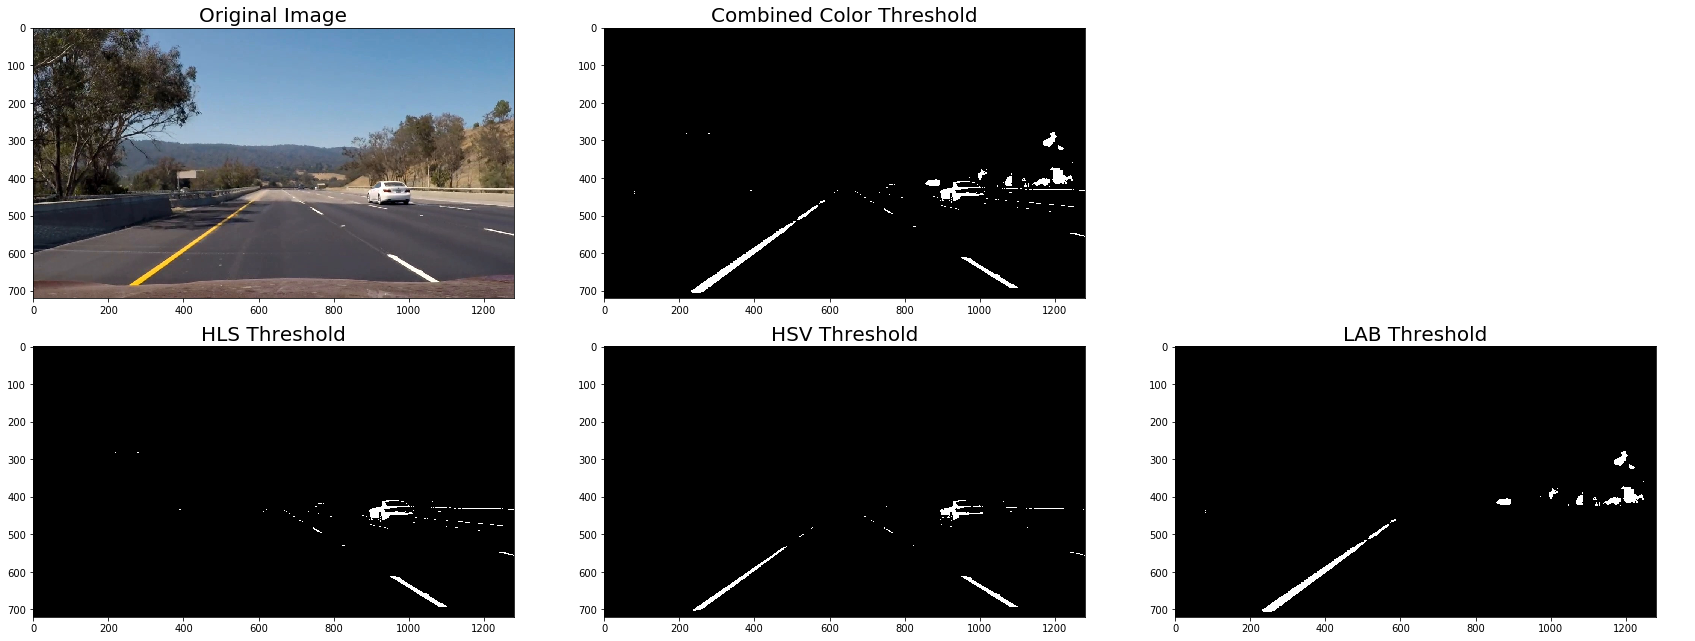

In [76]:
def color_threshold_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_14.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    color_threshold_tuple = build_color_threshold(undistorted_img, 
                                            hls_thresh = hls_thresh, 
                                            hsv_thresh = hsv_thresh, 
                                            lab_thresh = lab_thresh)

    # Plot the result
    f, axis = plt.subplots(2, 3, figsize=(24, 9))
    axis[0][0].imshow(image)
    axis[0][0].set_title('Original Image', fontsize=20)

    axis[0][1].imshow(color_threshold_tuple[0], cmap='gray')
    axis[0][1].set_title('Combined Color Threshold', fontsize=20)

    axis[0][2].axis('off')

    axis[1][0].imshow(color_threshold_tuple[1], cmap='gray')
    axis[1][0].set_title('HLS Threshold', fontsize=20)

    axis[1][1].imshow(color_threshold_tuple[2], cmap='gray')
    axis[1][1].set_title('HSV Threshold', fontsize=20)

    axis[1][2].imshow(color_threshold_tuple[3], cmap='gray')
    axis[1][2].set_title('LAB Threshold', fontsize=20)

    f.tight_layout()
    
color_threshold_test()

## Step 5. Now we want to combine the shape gradient and the color threshold into one binary image.

In [23]:
def build_binary_threshold(image, objpoints, imgpoints, sobel_kernel):
    shape_tuple = build_shape_gradient(image, sobel_kernel)
    combined_gradient = shape_tuple[len(shape_tuple) - 1]
    
    color_threshold_tuple = build_color_threshold(image, 
                                        hls_thresh = hls_thresh, 
                                        hsv_thresh = hsv_thresh, 
                                        lab_thresh = lab_thresh)
    color_threshold = color_threshold_tuple[0]
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.uint8(np.dstack(( np.zeros_like(combined_gradient), combined_gradient, color_threshold)) * 255)

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(combined_gradient)
    combined_binary[(color_threshold == 1) | (combined_gradient == 1)] = 1
    
    return (combined_gradient, color_binary, combined_binary)

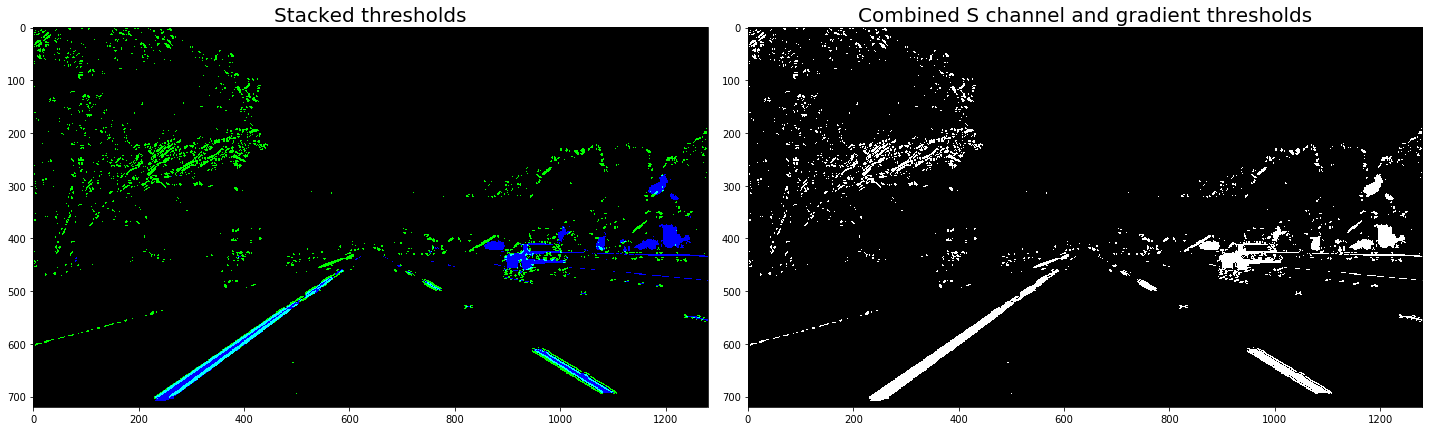

In [75]:
def combined_binary_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_14.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    combined_gradient, color_binary, combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Stacked thresholds', fontsize=20)
    ax1.imshow(color_binary)

    ax2.set_title('Combined S channel and gradient thresholds', fontsize=20)
    ax2.imshow(combined_binary, cmap='gray')
    f.tight_layout()
    
combined_binary_test()

## Step 6. Build a perspective transform so that we can get a top-down view of the lane.

In [25]:
# Takes in an undistorted calibration image
def build_perspective_matrix(image, board_width, board_height, transform_area):
    src = np.float32(transform_area)

    top_bottom_offset = 10
    left_right_offset = 100
    img_size = (image.shape[1], image.shape[0])
    dst = np.float32([[left_right_offset, top_bottom_offset],
                      [img_size[0] - left_right_offset, top_bottom_offset], 
                      [img_size[0] - left_right_offset, img_size[1] - top_bottom_offset], 
                      [left_right_offset, img_size[1] - top_bottom_offset]])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inverse = cv2.getPerspectiveTransform(dst, src)
            
    return (M, M_inverse)

def apply_perspective_transform(image, perspective_M):
    img_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, perspective_M, img_size)

(560, 450)
(99.99999999999312, 9.999999999989011)
(700, 450)
(1179.9999999999984, 10.000000000009546)
(1230, 720)
(1179.9999999999989, 709.9999999999997)
(100, 720)
(99.9999999999996, 710.0000000000011)


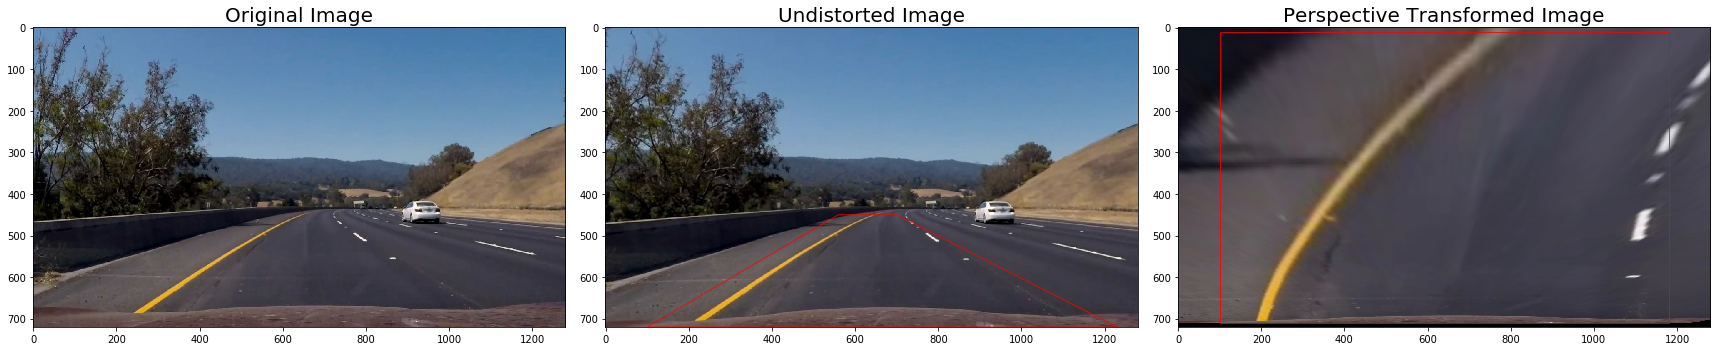

In [33]:
# Define the trapezoid for perspective transform
area_points = [(560, 450), 
               (700, 450), 
               (1280 - 50, 720), 
               (100, 720)]
#################################################

def build_perspective_transform(undistorted_img):
    transform_area = [area_points]

    perspective_M, perspective_M_inverse = build_perspective_matrix(undistorted_img, board_width, board_height, transform_area)
    
    return perspective_M, perspective_M_inverse
    
def build_perspective_transform_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_112.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    perspective_M, perspective_M_inverse = build_perspective_transform(undistorted_img)
    
    warped_image = apply_perspective_transform(undistorted_img, perspective_M)

    f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=20)

    ax2.imshow(undistorted_img)
    ax2.set_title('Undistorted Image', fontsize=20)
    # Create a Polygon patch
    polygon = patches.Polygon(area_points, alpha=.8, fill=False, color='red')

    # Add the patch to image
    ax2.add_patch(polygon)

    transformed_points = []

    for point in area_points:
        print(point)
        result = np.dot(perspective_M, [point[0], point[1], 1])
        result = (result[0] / result[2], result[1] / result[2])
        print(result)

        transformed_points.append(result)

    #print(transformed_points)    

    ax3.imshow(warped_image)
    ax3.set_title('Perspective Transformed Image', fontsize=20)
    # Create a Polygon patch
    polygon = patches.Polygon(transformed_points, alpha=.8, fill=False, color='red')

    # Add the patch to image
    ax3.add_patch(polygon)

    f.tight_layout()
    
build_perspective_transform_test()


## Step 7. Finding the lane lines from the binaries of the top-down view

### We have the perspective transform so we can try to find the lane lines from the combined_binary ###

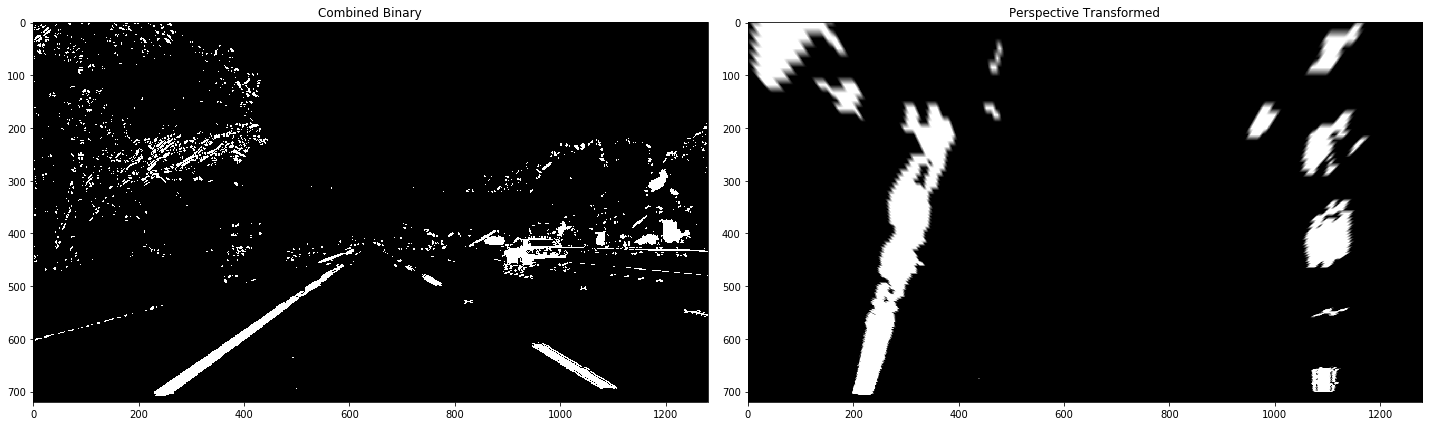

In [74]:
def binary_perspective_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_14.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    perspective_M, perspective_M_inverse = build_perspective_transform(undistorted_img)

    # Get the combined_binary
    combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)[2]

    # Apply perspective transform
    warped_image = apply_perspective_transform(combined_binary, perspective_M)

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title('Combined Binary')
    ax1.imshow(combined_binary, cmap='gray')

    ax2.set_title('Perspective Transformed')
    ax2.imshow(warped_image, cmap='gray')
    f.tight_layout()
    
binary_perspective_test()

### We will use histogram to find the center of each lane ###

In [36]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

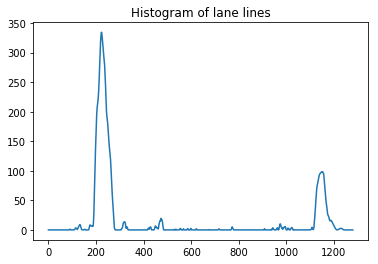

In [38]:
def line_find_histogram_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_43.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    perspective_M, perspective_M_inverse = build_perspective_transform(undistorted_img)

    # Get the combined_binary
    combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)[2]

    # Apply perspective transform
    warped_image = apply_perspective_transform(combined_binary, perspective_M)
    
    # Create histogram of image binary activations
    histogram = hist(warped_image)

    # Visualize the resulting histogram
    plt.title("Histogram of lane lines")
    plt.plot(histogram)
    
line_find_histogram_test()

### This is the histogram of the bottom half of the image. The peaks of the histogram are where the center of the lane lines most likely exists.

### We will are presuming that the middle of the lane is the bottom-center of the image. We split the histogram in half to detect where the start of each lane line. Therefore we split the frame in half into left and right frames ###

### In each half, we divide the frame into "n" windows along the y-axis. For me, I divided a half of the screen into 9 windows.

In [83]:
# HYPERPARAMETERS
# Choose the number of sliding windows
nwindows = 30
# Set the width of the windows +/- margin
margin = 50
# Set minimum number of pixels found to recenter window
minpix = 50

# Set height of windows - based on nwindows above and image shape
window_height = np.int(720 // nwindows)

### In each window we try to find the center of all pixels. This mediean point of each window is what we will try to create a ploynomial line. This is the sliding window technique.

In [41]:
def find_lane_pixels(warped_image):
    # Create histogram of image binary activations
    histogram = hist(warped_image)
    
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((warped_image, warped_image, warped_image)) * 255)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped_image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    warped_image_shape = warped_image.shape
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warped_image_shape[0] - (window + 1) * window_height
        win_y_high = warped_image_shape[0] - window * window_height
        
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2) 
        
        cv2.rectangle(out_img,(win_xright_low, win_y_low), (win_xright_high, win_y_high),(0, 255, 0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xleft_low) &  
                          (nonzerox < win_xleft_high)).nonzero()[0]
        
        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # Recalculate the center of the boxes #
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

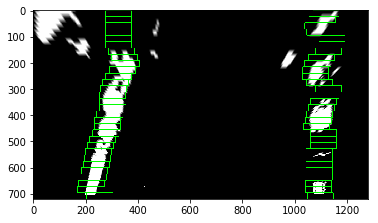

In [85]:
def sliding_window_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_14.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    perspective_M, perspective_M_inverse = build_perspective_transform(undistorted_img)

    # Get the combined_binary
    combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)[2]

    # Apply perspective transform
    warped_image = apply_perspective_transform(combined_binary, perspective_M)
    
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)

    plt.imshow(out_img)
    
sliding_window_test()

### Fitting a polynomial to the lane lines ###

In [44]:
def fit_polynomial(warped_image):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(warped_image)

    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return (left_fitx, right_fitx, out_img)

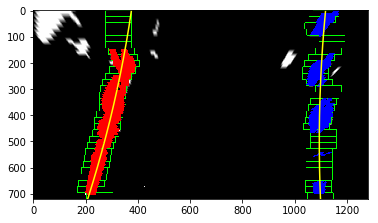

In [86]:
def poly_fit_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_14.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    perspective_M, perspective_M_inverse = build_perspective_transform(undistorted_img)

    # Get the combined_binary
    combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)[2]

    # Apply perspective transform
    warped_image = apply_perspective_transform(combined_binary, perspective_M)
    
    left_fitx, right_fitx, out_img = fit_polynomial(warped_image)

    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    plt.imshow(out_img)
    
poly_fit_test()

## Step 8. Drawing lane lines

In [54]:
def draw_lane(image, warped_image, left_fitx, right_fitx, ploty, perspective_M_inverse):
    left_lane_coords = np.stack((left_fitx, ploty), axis=-1)
    right_lane_coords = np.stack((right_fitx, ploty), axis=-1)
    
    combined_coords = []
    
    for i in range(0, len(left_lane_coords)):
        combined_coords.append(left_lane_coords[i])
        combined_coords.append(right_lane_coords[i])
    
    # Create a canvas for us to draw on.
    image_size = warped_image.shape
    output_image = np.zeros((image_size[0], image_size[1], 3), dtype=np.uint8)
    
    # Use fillpoly to draw the lane line
    cv2.fillPoly(output_image, np.int_([combined_coords]), (0,255, 0))
    cv2.polylines(output_image, np.int32([left_lane_coords]), isClosed=False, color=(255,0,0), thickness=15)
    cv2.polylines(output_image, np.int32([right_lane_coords]), isClosed=False, color=(0,0,255), thickness=15)
    
    # Transform the image back to the scene
    output_image = apply_perspective_transform(output_image, perspective_M_inverse)
    
    # Combine the result with the original image
    output_image = cv2.addWeighted(output_image, 0.6, image, 1, 0)
    
    return output_image

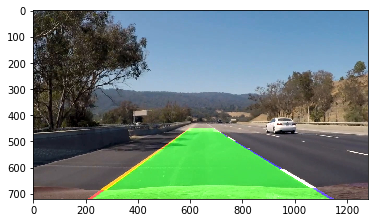

In [87]:
def draw_line_test():
    # Read in an image
    image = mpimg.imread('../test_images/trouble_image_14.jpg')

    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    # Build perspective matrixes
    perspective_M, perspective_M_inverse = build_perspective_transform(undistorted_img)

    # Build binary
    combined_gradient, color_binary, combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)

    # Apply perspective transform
    warped_image = apply_perspective_transform(combined_binary, perspective_M)

    # Find the lane polynomials
    left_fitx, right_fitx, out_img = fit_polynomial(warped_image)

    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])

    result = draw_lane(image, warped_image, left_fitx, right_fitx, ploty, perspective_M_inverse)

    plt.imshow(result)

    
    
draw_line_test()


## Step 9. Determine the center of the lane and curvature of the road.

### Finding the curvature of a lane.

I used this [tutorial](https://www.intmath.com/applications-differentiation/8-radius-curvature.php) to help derive the formula to finding the curvature of the road.

The conversion from pixel to meters is dependent on the trapezoid chosen for the perspective transform. I used the dash lines and what I know about the width between the left and right lane lines to estimate the pixel to meters ratio.

### Calculate the center
Find the midpoint between the first point (point closest to the car) on the fitted lanes. Then subtract this from the center of the wrapped image.
##### Result:
    val < 0: Left of center
    val > 0: Right of center

In [136]:
# Pixel Conversion

# Define conversions in x and y from pixels space to meters
ym_per_pix = 18 / 720 # meters per pixel in y dimension
xm_per_pix = 3.7 / 700 # meters per pixel in x dimension

In [128]:
def calculate_road_curvature_and_center(image, warped_image, left_fitx, right_fitx, ploty):
    
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    avg_rad = round(np.mean([left_curverad, right_curverad]),0)
    
    # Calculate the center
    # Find the midpoint between the first point (point closest to the car) on the fitted lanes.
    # Then subtract this from the center of the wrapped image.
    # Result:
    # < 0: Left of center
    # > 0: Right of center
    image_center = image.shape[1] / 2
    lane_center = (right_fitx[719] + left_fitx[719]) / 2
    center_offset = image_center - lane_center
    
    # Convert to meters
    center_offset *= xm_per_pix
    
    return (left_curverad, right_curverad, avg_rad, center_offset)



In [58]:
def draw_info(image, left_curverad, right_curverad, avg_rad, center_offset):
    font = cv2.FONT_HERSHEY_DUPLEX
    text = "Left Curve Rad: {0}m".format(round(left_curverad, 3))
    cv2.putText(image, text,(10, 50), font, 1, (255,255,255), 1, cv2.LINE_AA)
    
    text = "Right Curve Rad: {0}m".format(round(right_curverad, 3))
    cv2.putText(image, text,(10, 100), font, 1, (255,255,255), 1, cv2.LINE_AA)
    
    text = "Center Offset: {0}m".format(round(center_offset, 3))
    cv2.putText(image, text,(10, 150), font, 1, (255,255,255), 1, cv2.LINE_AA)
    
    return image

In [129]:
def process_image(image):
    # Undistort the image
    undistorted_img = undistort_img(image, objpoints, imgpoints)
    
    # Build perspective matrixes
    perspective_M, perspective_M_inverse = build_perspective_transform(undistorted_img)
    
    # Build binary
    combined_gradient, color_binary, combined_binary = build_binary_threshold(undistorted_img, objpoints, imgpoints, ksize)
    
    # Apply perspective transform
    warped_image = apply_perspective_transform(combined_binary, perspective_M)
    
    # Find the lane polynomials
    left_fitx, right_fitx, out_img = fit_polynomial(warped_image)
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0])
    
    left_curverad, right_curverad, avg_rad, center_offset = calculate_road_curvature_and_center(image, warped_image, left_fitx, right_fitx, ploty)
    result = draw_lane(image, warped_image, left_fitx, right_fitx, ploty, perspective_M_inverse)
    result = draw_info(result, left_curverad, right_curverad, avg_rad, center_offset)
    
    return result

In [131]:
def full_test():
    # Read in an image
    image = mpimg.imread('../test_images/my_test_image_11.jpg')

    result = process_image(image)
    plt.imshow(result)

full_test()
print("Done")

Done


## Test with test images

In [139]:
def process_all_test_images():
    # Make a list of calibration images
    images = glob.glob('../test_images/*.jpg')
    # images = glob.glob('../trouble_images/original_images/*.jpg')

    # Create output calibration path
    output_path = '../output_images/test_images/'
    # output_path = '../trouble_images/result_images_2/'

    try:
        if not os.path.exists(output_path):
            os.makedirs(output_path)
    except OSError:  
        print ("Creation of the directory %s failed" % output_path)

    for fname in images:
        image = mpimg.imread(fname)
        file_name = fname[fname.rfind('/') + 1:]

        result = process_image(image)

        plt.imsave(output_path + file_name, result)

    print("Done")
    
process_all_test_images()

Done


## Test with videos

In [64]:
# Create output calibration path
original_output_path = '../trouble_images/original_images/'
result_output_path = '../trouble_images/result_images/'

create_directory(original_output_path)    
create_directory(result_output_path)

In [133]:
# Video Path

video_file_path = '../project_video.mp4'
video_file_output_path = '../output_project_video.mp4'

# video_file_path = '../test_video_2.mp4'
# video_file_output_path = '../output_test_video_2.mp4'

# video_file_path = '../challenge_video.mp4'
# video_file_output_path = '../output_challenge_video.mp4'

video_input1 = VideoFileClip(video_file_path)

### Process video

In [137]:
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_file_output_path, audio=False)

print("Done")

[MoviePy] >>>> Building video ../output_project_video.mp4
[MoviePy] Writing video ../output_project_video.mp4


100%|█████████▉| 1260/1261 [17:55<00:00,  4.70it/s]   


[MoviePy] Done.
[MoviePy] >>>> Video ready: ../output_project_video.mp4 

CPU times: user 38min 36s, sys: 1min 9s, total: 39min 46s
Wall time: 17min 56s
Done


### Process video frame by frame

In [73]:
trouble_count = 1
def process_video_image(image):
    global trouble_count
    
    file_name = "trouble_image_{0}".format(trouble_count)
    plt.imsave(original_output_path + file_name, image)
    result = process_image(image)
    plt.imsave(result_output_path + file_name, result)
        
    trouble_count = trouble_count + 1

for frame in video_input1.iter_frames():
    process_video_image(frame)

print("Done")

Done


## Discussion

### Briefly discuss any problems / issues you faced in your implementation of this project. Where will your pipeline likely fail? What could you do to make it more robust?

This project was really fun and challenging project for me. I spent a lot of my time refining the gradient and getting a good result from the color threshold binary. Also, I ran into an issue where the Jupyter notebook was reusing variables that made me to get inconsistant results.

In the end, I realized that there's no single way of detecting this and I haven't even try to optimize this code so that I don't need to blind search every single frame. The pipeline will fail during various lighting condition that makes the lines in darker shadows, if the car isn't centered on the lane, or the camera is in direct sunlight.